# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

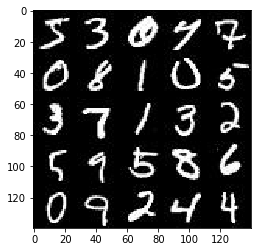

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

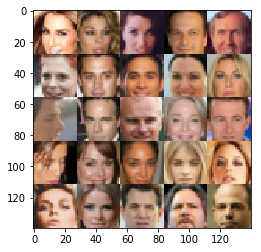

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/jason/anaconda/envs/aind/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests
from scipy.stats import truncnorm
    
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs_image")
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="inputs_z")
    lr = tf.placeholder(tf.float32, shape=(), name="lr")
    return inputs_image, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
from functools import reduce

def discriminator(images, reuse=False):
    
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)

    """

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        # 1st layer, where leaky relu has the hyperparameter 0.1 and it is different from other layers
        # if you modify any hyperparameter below, it is highly probable that you cannot get the result
        # also, the first layer should not add batch_normalization, which is mentioned in the video while reason is not cleared
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        
        flat = tf.reshape(dropout3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)  
        
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
            
    """
        
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        alpha = 0.1
        drop = 0.5 if is_train is True else 1.0
            
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=drop)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=drop)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=drop)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real, out = discriminator(input_real, reuse=False)
    d_logits_fake, out = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=(tf.zeros_like(d_logits_real) + .1)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake) * (1 - smooth)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # not sure the meaning
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z =  truncnorm(-1, 1).rvs(size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    image_width, image_height, image_channels = data_shape[1:]  
    
    inputs_image, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_image, inputs_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                batch_z = truncnorm(-1, 1).rvs(size=[batch_size, z_dim]) # the size here refer to output size
                _ = sess.run(d_train_opt, feed_dict={inputs_image: batch_images, inputs_z: batch_z, lr:learning_rate})
                # why I need to add inputs_image in g_loss? if not, error would be reported
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate, inputs_image:batch_images}) 
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_image: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 3.1287
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 2.6135
Epoch 1/2... Discriminator Loss: 2.2257... Generator Loss: 0.3331
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 2.0207
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.1247
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 3.0135
Epoch 1/2... Discriminator Loss: 2.6460... Generator Loss: 0.3288
Epoch 1/2... Discriminator Loss: 1.0874... Generator Loss: 3.9800
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 1.5417
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.4297


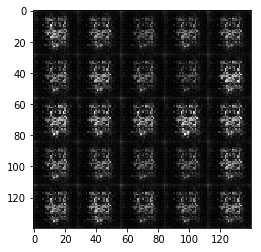

Epoch 1/2... Discriminator Loss: 0.7341... Generator Loss: 1.5955
Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 1.6188
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 2.3541
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 1.8572
Epoch 1/2... Discriminator Loss: 0.6948... Generator Loss: 1.9383
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 1.4828
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.4849
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 2.1238


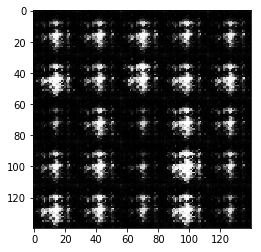

Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.5651
Epoch 1/2... Discriminator Loss: 0.7236... Generator Loss: 1.6306
Epoch 1/2... Discriminator Loss: 0.7235... Generator Loss: 2.6525
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 2.0464
Epoch 1/2... Discriminator Loss: 0.6890... Generator Loss: 1.7062
Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 3.0180
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 1.5876
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.0780
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 3.7088
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 2.8162


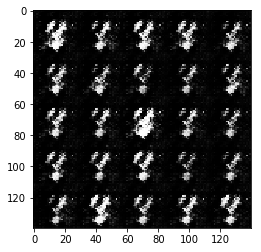

Epoch 1/2... Discriminator Loss: 0.7013... Generator Loss: 1.7892
Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 1.3849
Epoch 1/2... Discriminator Loss: 0.7151... Generator Loss: 1.6181
Epoch 1/2... Discriminator Loss: 0.8109... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 0.7076... Generator Loss: 1.9290
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 1.3182
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.7804
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.7998
Epoch 1/2... Discriminator Loss: 0.8653... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 1.0042


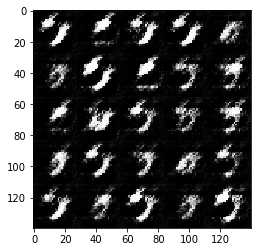

Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 1.6315
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 2.2994
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.7071... Generator Loss: 1.7827
Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 1.8705
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 1.7939
Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 0.6880... Generator Loss: 1.8962
Epoch 1/2... Discriminator Loss: 0.7017... Generator Loss: 1.8925


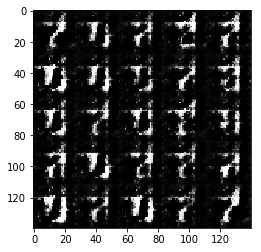

Epoch 1/2... Discriminator Loss: 0.7159... Generator Loss: 2.0018
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.7405
Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.4355
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.2715
Epoch 1/2... Discriminator Loss: 0.8638... Generator Loss: 2.7191
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.2345
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 2.5929
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.5451
Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 1.9497


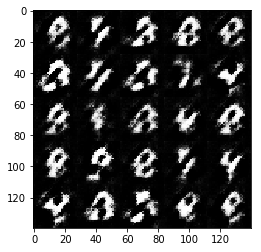

Epoch 1/2... Discriminator Loss: 0.7774... Generator Loss: 1.4702
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 0.8248... Generator Loss: 1.5215
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 2.0458
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 1.2825
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 1.8719
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 2.2258
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.6002
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.9961


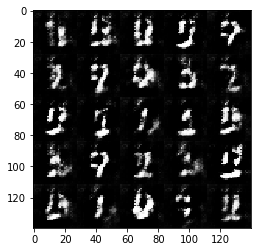

Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 1.3508
Epoch 1/2... Discriminator Loss: 0.8832... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 1.0819
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.3769
Epoch 1/2... Discriminator Loss: 0.8498... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 1.1545
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 2.1287


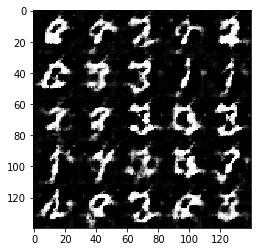

Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.1958
Epoch 1/2... Discriminator Loss: 0.8649... Generator Loss: 1.5843
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 2.0636
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.8754
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 1.0806
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 1.9535
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.6415
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 1.7959
Epoch 1/2... Discriminator Loss: 0.9518... Generator Loss: 0.9981


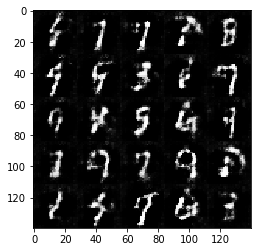

Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.4944
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 1.0225
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 1.3659
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.3412
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 1.0136
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 1.6119
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 1.1825
Epoch 2/2... Discriminator Loss: 0.9279... Generator Loss: 1.3186
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.2769
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.8630


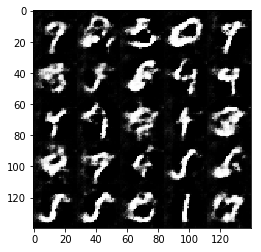

Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.5955
Epoch 2/2... Discriminator Loss: 1.1025... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 2.0562
Epoch 2/2... Discriminator Loss: 0.9309... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 1.5050
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 1.5416
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 0.6871


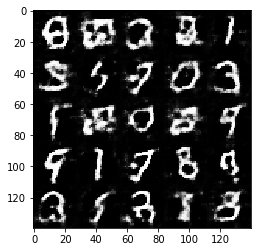

Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 1.6082
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.4804
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 1.3016
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 1.1681
Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 0.9221
Epoch 2/2... Discriminator Loss: 0.8779... Generator Loss: 1.4681
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 1.2379
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 1.6273
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 0.7794


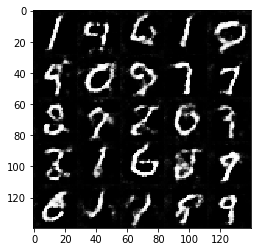

Epoch 2/2... Discriminator Loss: 0.9954... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 1.8796
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.9251
Epoch 2/2... Discriminator Loss: 1.1201... Generator Loss: 0.7277
Epoch 2/2... Discriminator Loss: 0.9746... Generator Loss: 1.1586
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.8667
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 1.0486
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 1.5867


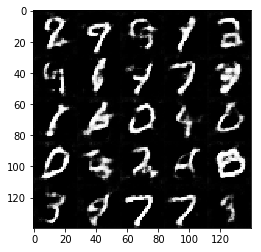

Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 1.1821... Generator Loss: 1.7887
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 1.0956
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.7943
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.6431
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.2602
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 1.2797
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.5936


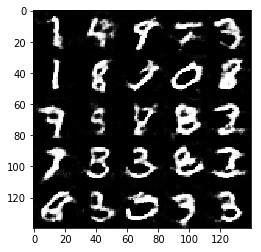

Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 1.2381
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 0.8130
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.3276
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.9570
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 0.8884... Generator Loss: 1.1225
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.1640


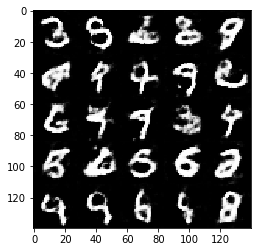

Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.3778
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 1.1033
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.2599
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.0459
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.7635
Epoch 2/2... Discriminator Loss: 1.2655... Generator Loss: 0.5991
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.9217


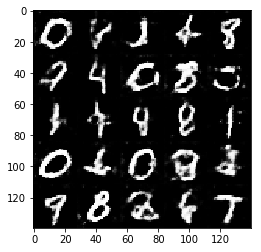

Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 1.3866
Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 1.5173
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 1.1107
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 1.5289
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 0.9143... Generator Loss: 1.1827
Epoch 2/2... Discriminator Loss: 0.9429... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 0.8249


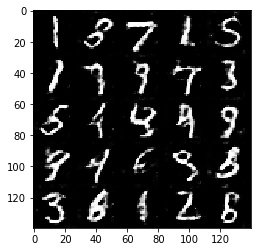

Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 1.2239
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.4985
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 1.1451
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 0.6893
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 1.4484
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.6005


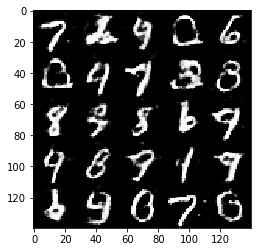

Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 0.9325
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.2785
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.9841
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.0666
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 0.8900


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    print(mnist_dataset.shape, mnist_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 3.2780
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 5.6752
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 3.3901
Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 2.8068
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 5.3803
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 3.7939
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 1.7782
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.7848


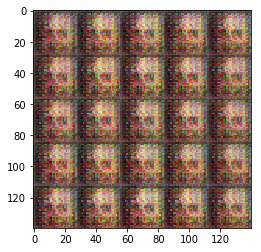

Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 2.3452
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.9610
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.7653
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 4.7951
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 2.2167
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.6132
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 1.7169


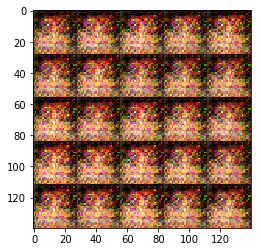

Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.4849
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 2.1302
Epoch 1/1... Discriminator Loss: 0.7376... Generator Loss: 1.3729
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.8943
Epoch 1/1... Discriminator Loss: 0.6829... Generator Loss: 2.1530
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 1.4864
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.7975


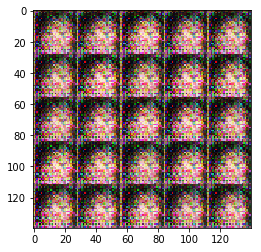

Epoch 1/1... Discriminator Loss: 0.7025... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.7195
Epoch 1/1... Discriminator Loss: 0.7327... Generator Loss: 2.9400
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.4911
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6262


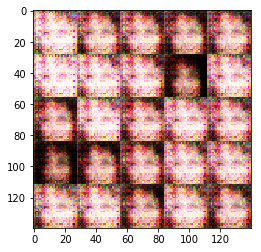

Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.9763
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.9071
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7557


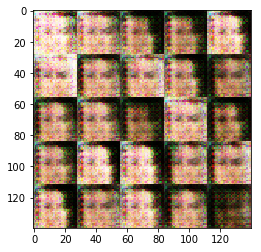

Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.7234
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.0397


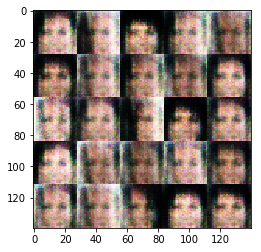

Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.4138
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 2.0276
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9996


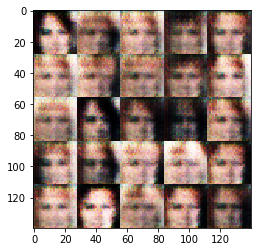

Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 1.6460
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 2.3570
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 1.0264


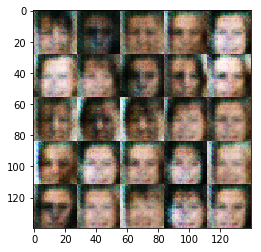

Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.5081
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.2835
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.1934


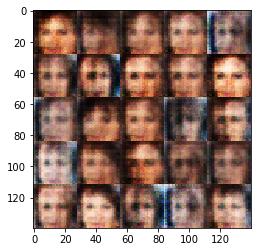

Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.6079
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.1092
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 0.9736


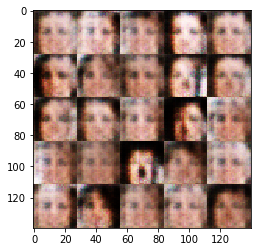

Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.3950
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.3461
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.6395
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8294


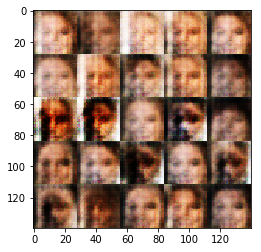

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.3949
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.1245
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.2987


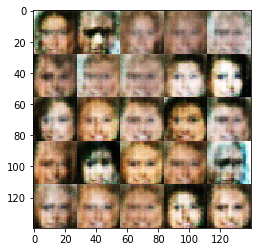

Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.5898
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.6333
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.5799
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.1407


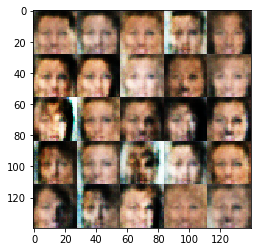

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.5715
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.1546


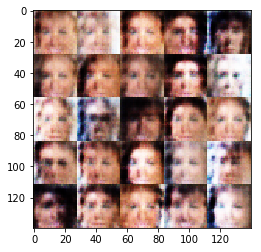

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.1027


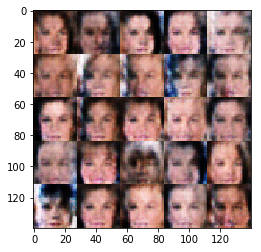

Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 1.6584
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.2934


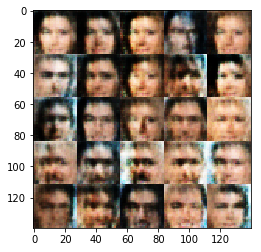

Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.6567
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.2632
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.4758
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.8759


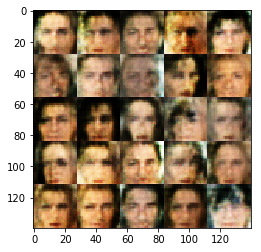

Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.7380
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.4861
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.3303


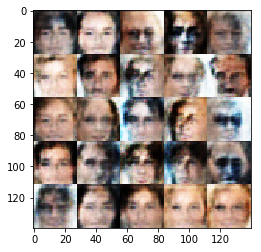

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 1.8797
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.5523
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 1.0978


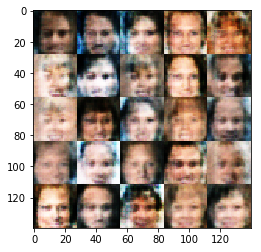

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.9629


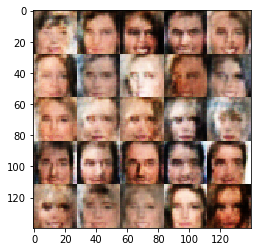

Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.5270
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.9825


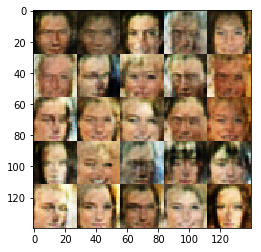

Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.2682
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.1773


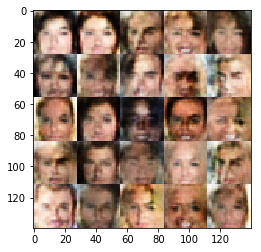

Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.1068
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.7310


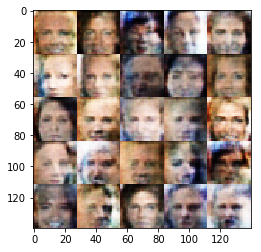

Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.2631
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.7658


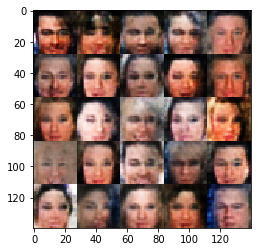

Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.7851
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.6011


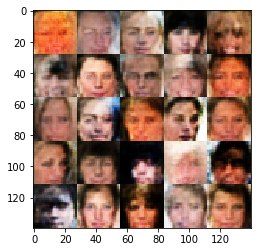

Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.8409


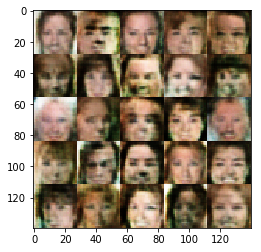

Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.4763
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.2318


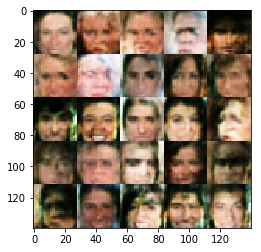

Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.8846
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.0247


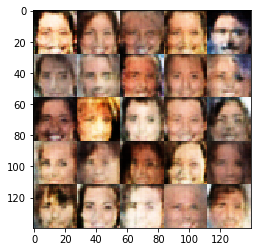

Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 1.5706
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.0398


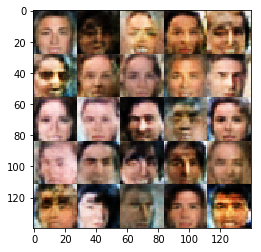

Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.1699
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 1.5376
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.9633
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.5371


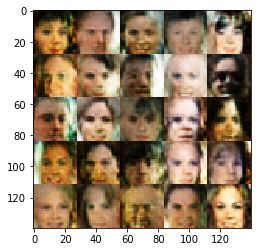

Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.3171
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7011


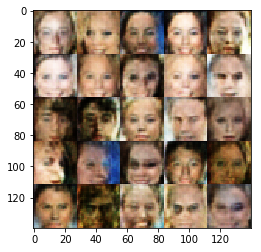

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.5290


In [15]:
batch_size = 64         #cannot be modified / reason: ugly result
z_dim = 100             
learning_rate = 0.0002   #cannot be modified, the original is 0.002. If it is increased to 0.005, then the result is getting from good to desaster
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    print(celeba_dataset.shape, celeba_dataset.image_mode)
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.